<a href="https://colab.research.google.com/github/PromitHal/AI_ML/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import os
import tensorflow as tf
import time
import functools
import matplotlib.pyplot as plt
import PIL.Image
import IPython.display as display
import numpy as np
import cv2

# Functions for loading images...

In [39]:
# Function to load an image.. using OPEN CV
def load_image(image_path:str)->"image":
  img=cv2.imread(image_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))
  img=img/255.
  img=np.expand_dims(img,axis=0)
  return img
# Function convert numpy array image to tensorflow tensor
def image2tensor(img:np.array):
  tensor_image=tf.convert_to_tensor(img)
  return tensor_image

# Path to content and style images.
content_path='/content/PromitPhoto.png'
style_path='/content/style.jpg'

# Displaying content and style image

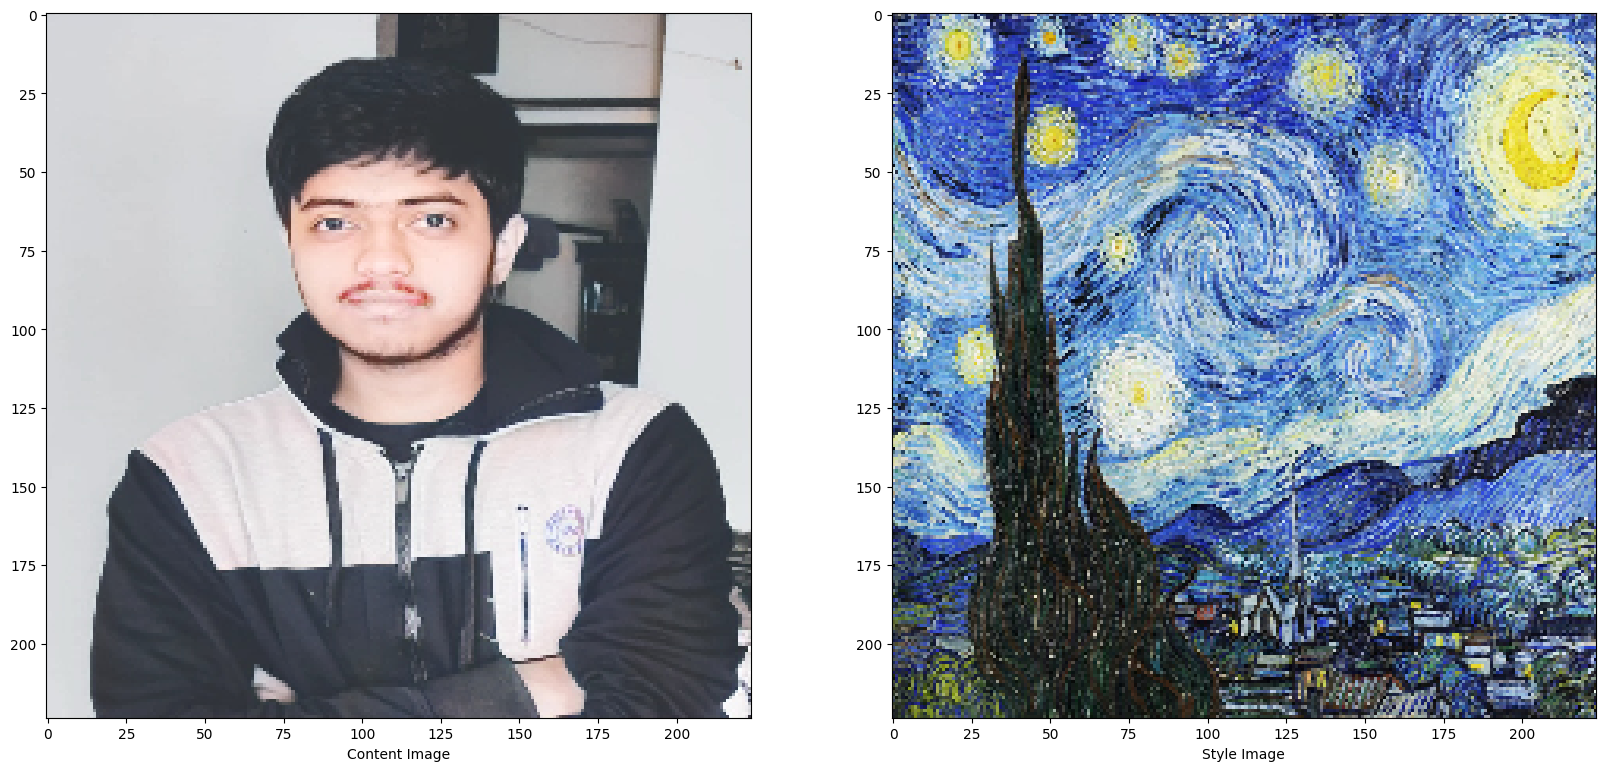

In [40]:
content_img=load_image(content_path)
content_image=np.squeeze(content_img,axis=0)
style_img=load_image(style_path)
style_image=np.squeeze(style_img,axis=0)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(content_image)
plt.xlabel('Content Image')
plt.subplot(1,2,2)
plt.imshow(style_image)
plt.xlabel('Style Image')
plt.show()

# Chosing a model
We have to chose a CNN which has been trained on a wide variety of images. This would enable us to extract both high level and low level features from an image. VGG-19 is one such network we can use which has been trained on the imagenet dataset.

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for idx,layer in enumerate(vgg.layers):
  print(idx,layer.name)

80134624/80134624 [==============================] - 3s 0us/step
0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


Choosing layers for style block and content block

In [31]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv2',
                'block4_conv2',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
#-----------------------------------------------------------------------------------------

def vgg_model(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# Gram Matrix: Gram Matrix is used to compute the style of an image, this is from prior art.
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Clipping the image to ensure pixel values are within 0-1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Custom Model Class

In [32]:
class Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Model, self).__init__()
    self.vgg = vgg_model(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


#----------------------------------------------------------------------------
extractor =Model(style_layers, content_layers) # This is our custom model for feature extraction
results = extractor(tf.constant(content_img))
style_targets = extractor(style_img)['style']  # This is the target style features
content_targets = extractor(content_img)['content'] # This is the target content features

In [45]:
image = tf.Variable(content_img) # Converting  input tensor image into a tensorflow variable
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) # Adam Optimizer

# Custom loss function combining style loss and content loss
total_loss=w_style* style_loss+w_content* content_loss

In [34]:
w_style=1e-8 # weight associated with style
w_content=1e-8 # weight associated with content
def custom_style_loss(outputs):
    style_out = outputs['style']
    content_out = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_out[name]-style_targets[name])**2)
                           for name in style_out.keys()])
    style_loss *= w_style / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_out[name]-content_targets[name])**2)
                             for name in content_out.keys()])
    content_loss *= w_content / num_content_layers
    loss = style_loss + content_loss
    return loss

# Training Step

In [35]:
@tf.function()
def training_style(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = custom_style_loss(outputs)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [46]:
num_epochs=70 # Number of iterations to optimize the image, we really need to adjust this depending on our requirements
losses=[]
for epoch in range(num_epochs):
  training_style(image)
  loss=custom_style_loss(extractor(image))
  losses.append(loss.numpy())
  print("Epoch: {}/{}, Loss: {}".format(epoch+1,num_epochs,loss))

Epoch: 1/70, Loss: 208.70138549804688
Epoch: 2/70, Loss: 204.28887939453125
Epoch: 3/70, Loss: 199.5668487548828
Epoch: 4/70, Loss: 194.6456756591797
Epoch: 5/70, Loss: 189.59262084960938
Epoch: 6/70, Loss: 184.49139404296875
Epoch: 7/70, Loss: 179.40127563476562
Epoch: 8/70, Loss: 174.3371124267578
Epoch: 9/70, Loss: 169.36253356933594
Epoch: 10/70, Loss: 164.4510498046875
Epoch: 11/70, Loss: 159.56126403808594
Epoch: 12/70, Loss: 154.6887664794922
Epoch: 13/70, Loss: 149.8380584716797
Epoch: 14/70, Loss: 145.0128173828125
Epoch: 15/70, Loss: 140.2150115966797
Epoch: 16/70, Loss: 135.44061279296875
Epoch: 17/70, Loss: 130.69625854492188
Epoch: 18/70, Loss: 125.98097229003906
Epoch: 19/70, Loss: 121.30592346191406
Epoch: 20/70, Loss: 116.68112182617188
Epoch: 21/70, Loss: 112.09793853759766
Epoch: 22/70, Loss: 107.56793975830078
Epoch: 23/70, Loss: 103.10458374023438
Epoch: 24/70, Loss: 98.70881652832031
Epoch: 25/70, Loss: 94.39856719970703
Epoch: 26/70, Loss: 90.18865966796875
Epoch:

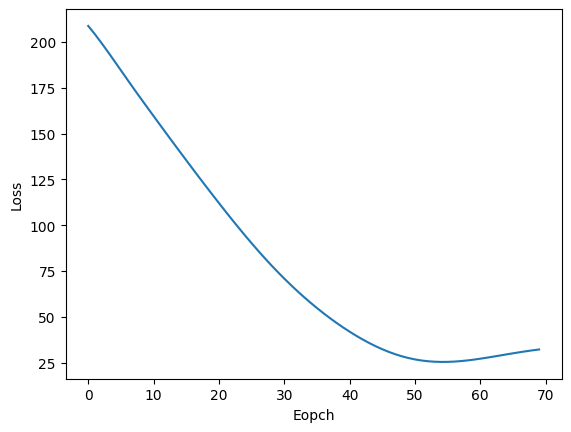

In [47]:
plt.plot(losses)
plt.xlabel('Eopch')
plt.ylabel('Loss')
plt.show()


# Displaying my stylized image : 😎😎


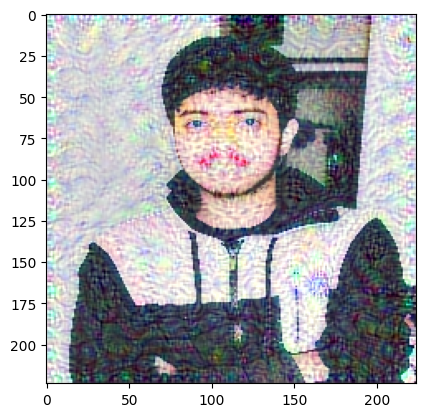

In [48]:
plt.imshow(np.squeeze(image.numpy(),axis=0))

# Testing on some more images....

In [53]:
def train(content_img_path:str,epochs=100):
  content_img=load_image(content_img_path)
  image = tf.Variable(content_img)
  for epoch in range(epochs):
    training_style(image)
    loss=custom_style_loss(extractor(image))
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(content_img,axis=0))
  plt.xlabel('Content Image')
  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(image.numpy(),axis=0))
  plt.xlabel('Stylized Image')
  plt.show()

  On some beautiful pics I managed to click during my travels.

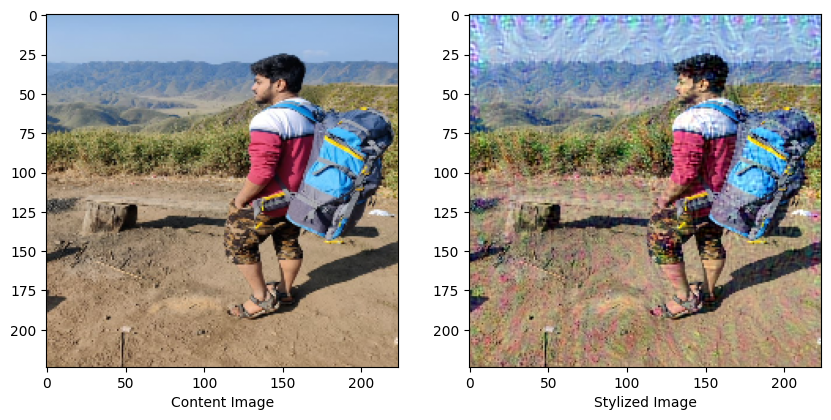

In [54]:
train('/content/2dc61378-d3c5-424b-992f-7effa53490df.jpeg',50)

At Dzukou Vally, Nagaland

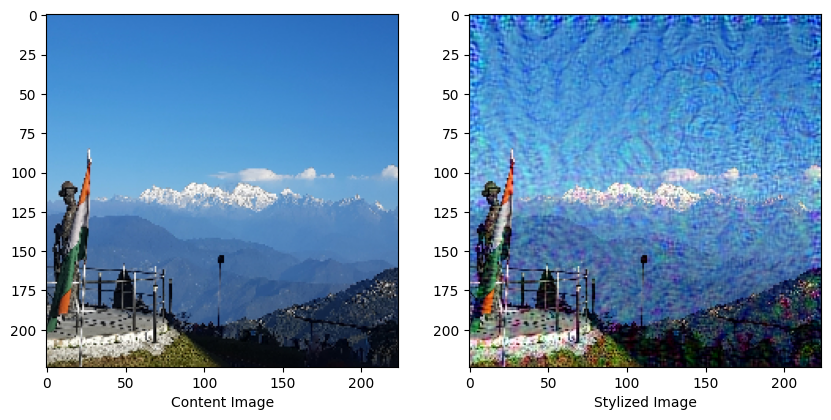

In [55]:
train('/content/20211201_073522.jpg',50)

Batashia Loop, Darjeeling, West Bengal (Mt. Kanchenjungha at the back)

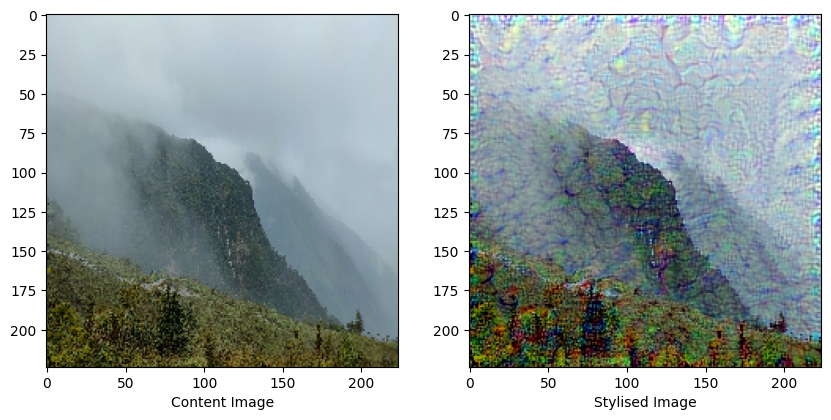

In [51]:
train('/content/Wakhaba Falls.jpg',50)

Wakhaba Falls, Meghalaya

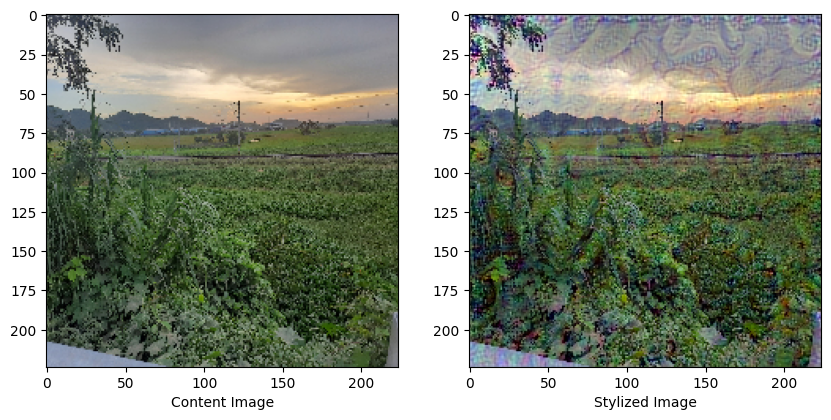

In [56]:
train('/content/cycle_scenery.jpg',40)

A random Sunset in Guwahati, Assam

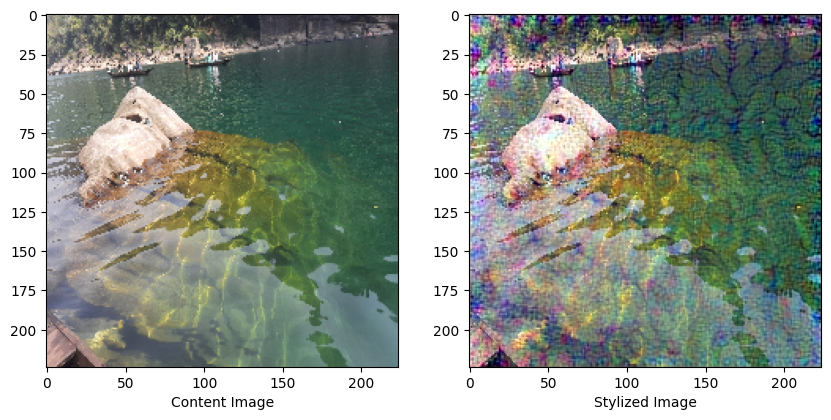

In [57]:
train('/content/dawki.jpg',50)

Dawki River (Cleanest in Asia), Indo_Ban Border at Meghalaya

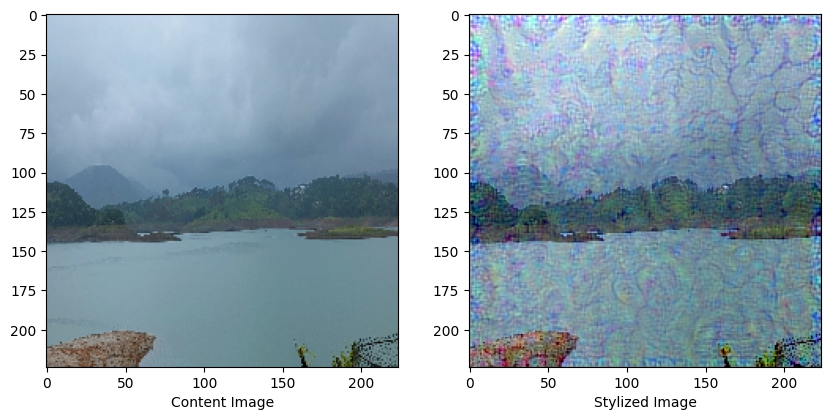

In [58]:
train('/content/umiam_lake.jpg',40)

Umiam Lake, Meghalaya

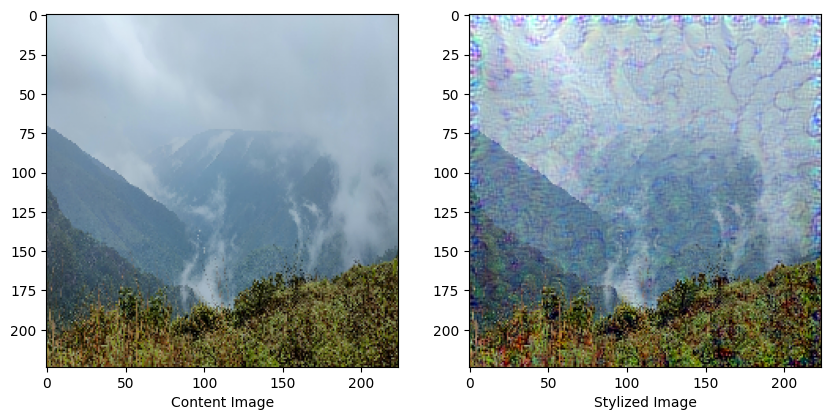

In [59]:
train('/content/Lauram.jpg',30)

Laitlum Canyon, Meghalaya


Enough Flex, time for citations:
1. Gatys, L. A., Ecker, A. S., & Bethge, M. (2016). Image style transfer using convolutional neural networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2414-2423).